<a href="https://colab.research.google.com/github/leejielong/resnet/blob/main/ResNet_subclassed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Subclassing with ResNets

Subclassing is a powerful technique in tensorflow which allows the developer to fully customize the network architecture, and enables the implementation of custom layers. In this notebook, we implement resnet50 via subclassing, referencing the architecture and hyperparameters from the original paper. Subclassing allows us to build custom layers, which can be re-used and combined into more complex models. 

We will also implement a custom training regime. When a custom training regime is required, tf.GradientTape can be used to fully control the training steps. This gives us full control over the loss function, eval function, optimizer, and additional actions can be taken during training.

### Dataset Preparation

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time

In [2]:
#Load Cifar-10 dataset
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
### normalise the images to pixel values (0,1)
x_train, x_test = x_train/255.0, x_test/255.0

In [4]:
# check the shapes of the images
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
# check the distribution of classes
(unique, counts) = np.unique(y_train, return_counts=True)
test = dict(zip(unique,counts))
print(test)

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


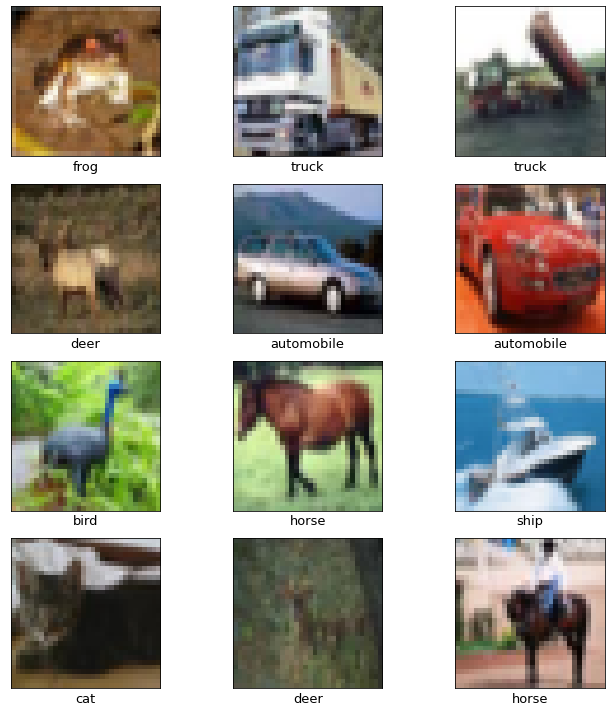

In [6]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(class_types[y_train[i][0]], fontsize=13)
plt.tight_layout()
plt.show()

In [7]:
# do one hot encoding for labels
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')


In [8]:
# train-test split
from sklearn.model_selection import train_test_split
x_train,x_val, y_train, y_val = train_test_split(x_train,
                                                 y_train_categorical,
                                                 test_size=0.20,
                                                 stratify=y_train_categorical,
                                                 random_state=42,
                                                 shuffle=True)

In [9]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


In [10]:
## include data augmentation
batch_size = 64
epochs = 100

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                horizontal_flip=True
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_datagen.flow(x_train,y_train,batch_size=batch_size)
valid_set_conv = valid_datagen.flow(x_val,y_val,batch_size=batch_size)

### Build Subclassed Models

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [12]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filter):
        super(ResidualBlock, self).__init__()

        self.conv1 = Conv2D(filter, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))
        self.bn1 = BatchNormalization()
        self.act1 = Activation(activations.relu)

        self.conv2=Conv2D(filter, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))
        self.bn2 = BatchNormalization()
        
        self.add3 = Add()
        self.act3 = Activation(activations.relu)

    def call(self,x):
        x_skip = x

        #first block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        #second block
        x = self.conv2(x)
        x = self.bn2(x)

        #add skip connection
        x = self.add3([x,x_skip])
        x = self.act3(x)
        
        return x

In [13]:
class BottleneckResidualBlock(tf.keras.layers.Layer):
    def __init__(self,filter,s):
        super(BottleneckResidualBlock, self).__init__()

        #first block
        self.conv1 = Conv2D(filter, kernel_size=(3,3), strides=(s,s), padding='same', kernel_regularizer=l2(0.001))
        self.bn1 = BatchNormalization()
        self.act1 = Activation(activations.relu)

        #second block
        self.conv2 = Conv2D(filter, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))
        self.bn2 = BatchNormalization()

        #transform residual to match dimension
        self.conv3 = Conv2D(filter, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_regularizer=l2(0.001))
        self.bn3 = BatchNormalization()

        #add skip connection
        self.add4 = Add()
        self.act4 = Activation(activations.relu)

    def call(self, x):
        x_skip = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x_skip = self.conv3(x_skip)
        x_skip = self.bn3(x_skip)

        x = self.add4([x,x_skip])
        x = self.act4(x)

        return x

In [14]:
class Resnet50(tf.keras.Model):
    def __init__(self):
        super(Resnet50,self).__init__()

        self.conv1 = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')
        self.bn1 = BatchNormalization()
        self.act1 = Activation(activations.relu)
        self.maxpool1 = MaxPooling2D((2,2), strides=(2,2))

        self.rb2_1 = ResidualBlock(filter=64)
        self.rb2_2 = ResidualBlock(filter=64)
        self.rb2_3 = ResidualBlock(filter=64)

        self.brb3_1 = BottleneckResidualBlock(filter=128,s=2)
        self.rb3_1 = ResidualBlock(filter=128)
        self.rb3_2 = ResidualBlock(filter=128)
        self.rb3_3 = ResidualBlock(filter=128)

        self.brb4_1 = BottleneckResidualBlock(filter=256,s=2)
        self.rb4_1 = ResidualBlock(filter=256)
        self.rb4_2 = ResidualBlock(filter=256)
        self.rb4_3 = ResidualBlock(filter=256)
        self.rb4_4 = ResidualBlock(filter=256)
        self.rb4_5 = ResidualBlock(filter=256)

        self.brb5_1 = BottleneckResidualBlock(filter=512,s=2)
        self.rb5_1 = ResidualBlock(filter=512)
        self.rb5_2 = ResidualBlock(filter=512)

        self.avgpool6 = AveragePooling2D((2,2), padding='same')
        self.flat6 = Flatten()
        self.dense6 = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')
    
    def call(self, x):

        #1st stage
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        #2nd stage
        x = self.rb2_1(x)
        x = self.rb2_2(x)
        x = self.rb2_3(x)

        #3rd stage
        x = self.brb3_1(x)
        x = self.rb3_1(x)
        x = self.rb3_2(x)
        x = self.rb3_3(x)

        #4th stage
        x = self.brb4_1(x)
        x = self.rb4_1(x)
        x = self.rb4_2(x)
        x = self.rb4_3(x)
        x = self.rb4_4(x)
        x = self.rb4_5(x)

        #5th stage
        x = self.brb5_1(x)
        x = self.rb5_1(x)
        x = self.rb5_2(x)

        #6th stage
        x = self.avgpool6(x)
        x = self.flat6(x)
        x = self.dense6(x)

        return x

In [15]:
# # Test Resnet50 class
# sample_resnet = Resnet50()
# temp_input = x_train[:10,:,:,:]
# temp_output = sample_resnet(temp_input)
# print(temp_output.shape)
# # print(temp_output)

### Customize Learning Rate Schedule

We implement a custom learning rate schedule that gradually reduces the learning rate to encourage convergence during training.

In [30]:
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#   def __init__(self, batch_size, epochs):
#     super(CustomSchedule, self).__init__()
#     self.steps_per_epoch = x_train.shape[0]/batch_size
#     # print(self.steps_per_epoch)

#   def __call__(self, step): #step is a tensor
#     lr = 1e-3
#     if tf.math.greater(step, tf.constant(180 * self.steps_per_epoch)):
#         lr *= 0.5e-3
#     elif tf.math.greater(step, tf.constant(160 * self.steps_per_epoch)):
#         lr *= 1e-3
#     elif tf.math.greater(step, tf.constant(120 * self.steps_per_epoch)):
#         lr *= 1e-2
#     elif tf.math.greater(step, tf.constant(80 * self.steps_per_epoch)):
#         lr *= 1e-1
#     return lr

In [34]:
learning_rate = CustomSchedule(batch_size,epochs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [36]:
# # Plot learning rate schedule
# temp_learning_rate_schedule = CustomSchedule(batch_size,epochs)
# lr = []
# for i in range(1000000):
#     lr.append(temp_learning_rate_schedule(i))

# plt.plot(lr)
# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")

### Customize Loss and Eval Function

We use categorical crossentropy loss as the labels are already one-hot encoded. As a reminder, categorical crossentropy loss is used when labels are one-hot encoded, and sparse categorical cross entropy loss is used when labels are not one-hot encoded.

In [19]:
def loss_function(real,pred):
    # print('In loss function...')
    # print(real.shape)
    # print(pred.shape)
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(real,pred)
    return loss

def accuracy_function(real,pred):
    accuracies = tf.equal(tf.argmax(real, axis=-1), tf.argmax(pred, axis=-1))
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    real = tf.cast(real, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(real)

# test loss and accuracy functions
# real = tf.constant([[[0, 1, 0], [0, 0, 1]]],dtype=tf.int64)
# pred = tf.constant([[[0.05, 0.95, 0], [0.1, 0.2, 0.8]]], dtype=tf.float32)
# print(loss_function(real,pred))
# print(accuracy_function(real,pred))

# initialise metric recorders
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.Mean(name='valid_accuracy')

### Customize Training Regime

There are a few key lessons to be learnt when building a custom training regime.
1. Eager execution is slow, graph execution is super fast. Use the `tf.function()` decorator to convert model for graph execution.
2. In `tf.function()`, the model is traced and converted to a graph at the first train step. From then on, no new variables should be initialised as the graph is constructed and re-tracing is expensive. Therefore when designing subclassed layers, we should place the layer instantiation in `__init__() `or `build()`, and make sure that new layers are not created in `call()`. What happens is that the train step invokes  `call()` for all layers in the model. Having layer instantiation in the `call()` step will re-create `tf.Variable` and cause `tf.function()` to throw `ValueError: tf.function-decorated function tried to create variables on non-first call`. This can be bypassed with `tf.config.run_functions_eagerly(False)`, however training is almost 100x slower.
3. When the training of a graph executed model is stopped abruptly, we need to call `tf.function` again to reset its variables before we restart training.
4. The generator produced from `ImageDataGenerator.flow()` loops indefinitely, although its size is `len(dataset)/batch_size`. So we have to manually break the loop when the number of train steps reaches `steps_per_epoch` to proceed to the next epoch.

In [20]:
# tf.config.run_functions_eagerly(False)

In [37]:
resnet = Resnet50()

@tf.function #calling tf.function resets its variables
def train_step(images, labels):
    # print('Inside train step...')
    with tf.GradientTape() as tape:
        preds = resnet(images)
        loss = loss_function(labels,preds)
    gradients = tape.gradient(loss, resnet.trainable_variables)
    optimizer.apply_gradients(zip(gradients, resnet.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(labels,preds))

In [38]:
valid_loss.reset_states()
valid_accuracy.reset_states()
train_loss.reset_states()
train_accuracy.reset_states()

steps_per_epoch = x_train.shape[0]/batch_size

history = {
    'epoch' : [],
    'train_loss' : [],
    'train_acc' : [],
    'val_loss' : [],
    'val_acc' : [],
    'time_taken': []
}

for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (images, labels)) in enumerate(train_set_conv):
        train_step(images,labels)
        # if batch%100 == 0:
        #     print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        if batch >= steps_per_epoch: #need to manually break the loop as datagen_flow loops indefinitely
            break
    
    #calculate validation results at end of epoch
    (x_test,y_test) = next(valid_set_conv)
    preds = resnet(x_test)
    loss = loss_function(y_test,preds)
    accuracy = accuracy_function(y_test,preds)
    valid_loss(loss)
    valid_accuracy(accuracy)

    history['epoch'].append(epoch+1)
    history['train_loss'].append(train_loss.result().numpy())
    history['train_acc'].append(train_accuracy.result().numpy())
    history['val_loss'].append(valid_loss.result().numpy())
    history['val_acc'].append(valid_accuracy.result().numpy())
    history['time_taken'].append(time.time() - start)

    print(f'Epoch: {(epoch+1):03} | Train Loss: {train_loss.result():.4f} | Train Acc: {train_accuracy.result():.4f} | Val Loss: {valid_loss.result():.4f} | Val Acc: {valid_accuracy.result():.4f} | Time Taken: {time.time() - start:.2f}s')

Epoch: 001 | Train Loss: 1.9284 | Train Acc: 0.2756 | Val Loss: 1.7836 | Val Acc: 0.3750 | Time Taken: 59.73s
Epoch: 002 | Train Loss: 1.5987 | Train Acc: 0.4112 | Val Loss: 1.6135 | Val Acc: 0.4453 | Time Taken: 25.31s
Epoch: 003 | Train Loss: 1.4503 | Train Acc: 0.4717 | Val Loss: 1.5376 | Val Acc: 0.4635 | Time Taken: 25.01s
Epoch: 004 | Train Loss: 1.3432 | Train Acc: 0.5157 | Val Loss: 1.4121 | Val Acc: 0.5273 | Time Taken: 25.26s
Epoch: 005 | Train Loss: 1.2685 | Train Acc: 0.5448 | Val Loss: 1.3610 | Val Acc: 0.5375 | Time Taken: 25.62s
Epoch: 006 | Train Loss: 1.2080 | Train Acc: 0.5695 | Val Loss: 1.3294 | Val Acc: 0.5443 | Time Taken: 25.23s
Epoch: 007 | Train Loss: 1.1589 | Train Acc: 0.5904 | Val Loss: 1.2883 | Val Acc: 0.5536 | Time Taken: 25.27s
Epoch: 008 | Train Loss: 1.1061 | Train Acc: 0.6079 | Val Loss: 1.2803 | Val Acc: 0.5684 | Time Taken: 25.28s
Epoch: 009 | Train Loss: 1.0695 | Train Acc: 0.6201 | Val Loss: 1.2771 | Val Acc: 0.5642 | Time Taken: 25.29s
Epoch: 010

In [39]:
resnet.summary()

Model: "resnet50_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           multiple                  9472      
_________________________________________________________________
batch_normalization_36 (Batc multiple                  256       
_________________________________________________________________
activation_33 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
residual_block_13 (ResidualB multiple                  74368     
_________________________________________________________________
residual_block_14 (ResidualB multiple                  74368     
_________________________________________________________________
residual_block_15 (ResidualB multiple                  7

In [49]:
loss = list(map(lambda x: x.numpy(), history['train_loss']))
val_loss = list(map(lambda x: x.numpy(), history['val_loss']))

acc = loss = list(map(lambda x: x.numpy(), history['train_acc']))
val_acc = list(map(lambda x: x.numpy(), history['val_acc']))

print(loss)
print(val_loss)
print(acc)
print(val_acc)

[0.2755591, 0.411242, 0.47172025, 0.51572484, 0.5447534, 0.5695138, 0.59035546, 0.60785246, 0.6200579, 0.63121504, 0.6463159, 0.65819687, 0.6632887, 0.674995, 0.6789387, 0.69071984, 0.69271666, 0.69740915, 0.7105132, 0.7167033, 0.7216703, 0.7201977, 0.7276358, 0.72933304, 0.73132986, 0.7396915, 0.7461062, 0.7483027, 0.7510733, 0.7546925, 0.7553415, 0.7615815, 0.758736, 0.76867014, 0.7717652, 0.77615815, 0.76989317, 0.7731879, 0.78214854, 0.7836961, 0.7873902, 0.7904353, 0.7853185, 0.79260683, 0.79427916, 0.8005691, 0.798772, 0.80411345, 0.8040885, 0.8084315, 0.80633485, 0.8101538, 0.811252, 0.816893, 0.81364816, 0.8186402, 0.8184655, 0.8213608, 0.8246306, 0.82692695, 0.8289487, 0.83069587, 0.8309954, 0.83371603, 0.8336162, 0.8390825, 0.83558804, 0.83571285, 0.840605, 0.8413788, 0.84152853, 0.8489417, 0.8477935, 0.8490665, 0.84964055, 0.85246104, 0.85460764, 0.85535645, 0.8551318, 0.8569289, 0.858726, 0.86022365, 0.86147165, 0.86304414, 0.8659395, 0.8642422, 0.8680611, 0.8659395, 0.8704

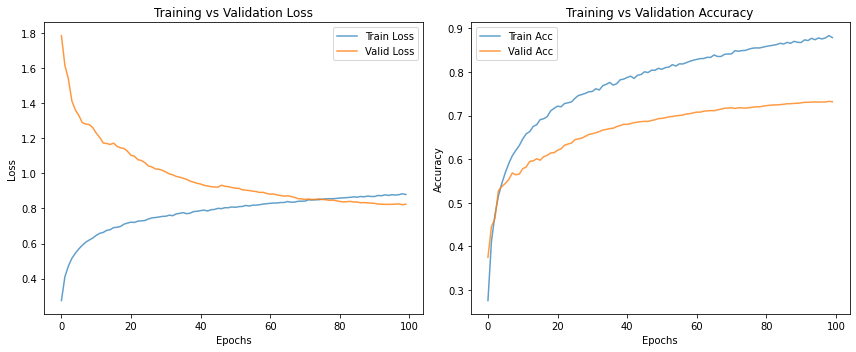

In [60]:
### Plot train and validation curves
epochs = range(len(loss))

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Training vs Validation Loss')
# plt.yscale('log')
plt.plot(epochs, loss, alpha=0.7, label='Train Loss')
plt.plot(epochs, val_loss, alpha=0.8, label='Valid Loss')
# plt.ylim(0.3,100)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.title('Training vs Validation Accuracy')
plt.plot(epochs, acc,alpha=0.7,label='Train Acc')
plt.plot(epochs, val_acc,alpha=0.78,label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()